In [3]:
# example of loading the keras facenet model
from keras.models import load_model
# load the model
model = load_model('facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)

2023-06-17 10:38:12.168119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 10:38:12.168272: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-17 10:38:12.168325: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-06-17 10:38:12.168374: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-06-17 10:38:12.168416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


In [10]:
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


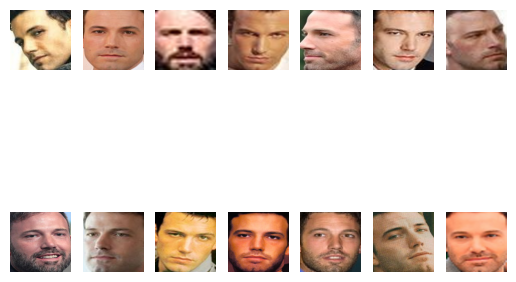

In [17]:
import os
from matplotlib import pyplot
# specify folder to plot
folder = 'data/train/ben_afflek/'
i = 1
# enumerate files
for filename in os.listdir(folder):
    # path
    path = folder + filename
    # get face
    face = extract_face(path)
    print(i, face.shape)
    # plot
    pyplot.subplot(2, 7, i)
    pyplot.axis('off')
    pyplot.imshow(face)
    i += 1
pyplot.show()

The load_dataset() function below takes a directory name such as ‘data/train/‘ and detects faces for each subdirectory (celebrity), assigning labels to each detected face.

In [28]:
def load_faces(directory):
    faces = list()
    # enumerate files
    for filename in os.listdir(directory):
        # path
        path = directory + filename
        # get face
        face = extract_face(path)
        # store
        faces.append(face)
    return faces

In [29]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in os.listdir(directory):
        # path
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not os.path.isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

In [31]:
import numpy as np

In [32]:
# load train dataset
trainX, trainy = load_dataset('data/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('data/val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
np.savez_compressed('dataset.npz', trainX, trainy, testX, testy)

>loaded 14 examples for class: ben_afflek
>loaded 17 examples for class: elton_john
>loaded 21 examples for class: jerry_seinfeld
>loaded 19 examples for class: madonna
>loaded 22 examples for class: mindy_kaling
(93, 160, 160, 3) (93,)
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: madonna
>loaded 5 examples for class: mindy_kaling
(25, 160, 160, 3) (25,)


<b>First, all of the photos in the ‘train‘ dataset are loaded, then faces are extracted, resulting in 93 samples with square face input and a class label string as output. Then the ‘val‘ dataset is loaded, providing 25 samples that can be used as a test dataset.

<b>Both datasets are then saved to a compressed NumPy array file called ‘dataset.npz‘ that is about three megabytes and is stored in the current working directory.

In [34]:
data = np.load('dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [43]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [45]:
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
np.savez_compressed('embeddings.npz', newTrainX, trainy, newTestX, testy)

(93, 128)
(25, 128)


 <b>The train dataset is transformed into 93 face embeddings, each comprised of a 128 element vector. The 25 examples in the test dataset were also suitably converted to face embeddings.

In [108]:
embd = np.load('embeddings.npz')

In [109]:
type(embd)

numpy.lib.npyio.NpzFile

In [119]:
embd1, names1, embd2, names2 = embd['arr_0'], embd['arr_1'], embd['arr_2'], embd['arr_3']
print(embd1.shape, embd2.shape, names1.shape, names2.shape)

(93, 128) (25, 128) (93,) (25,)


In [120]:
embds = np.concatenate((embd1, embd2), axis=0)
names = np.concatenate((names1, names2), axis=0)
print(names.shape, embds.shape)

(118,) (118, 128)


In [161]:
from deepface import DeepFace

In [163]:
result = DeepFace.verify(img1_path=embd1, img2_path=embd2)

ValueError: Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.

<AxesSubplot:>

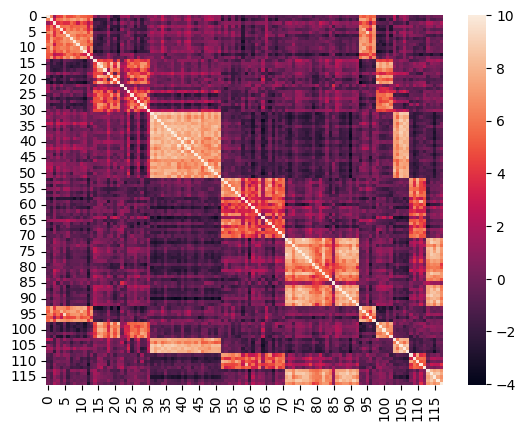

In [160]:
import sklearn
sim = (sklearn.metrics.pairwise.cosine_similarity(embds, embds) * 10)

import seaborn as sns
sns.heatmap(sim)

In [103]:
dt2 = data['arr_3'][0]
dt2

'ben_afflek'

In [104]:
yh = model.predict(im)
yh2 = model.predict(im2)

sc1 = accuracy_score(yh, yh2)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [47]:
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

In [48]:
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=93, test=25


In [54]:
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

In [55]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

In [56]:
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100,score_test*100))

Accuracy: train=100.000, test=100.000


In [79]:
# load faces
data = load('dataset.npz')
testX_faces = data['arr_2']

In [80]:
from random import choice
from numpy import load
from numpy import expand_dims
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

In [81]:
random_face_name

array(['elton_john'], dtype='<U14')

In [82]:
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

In [83]:
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

Predicted: elton_john (89.248)
Expected: elton_john


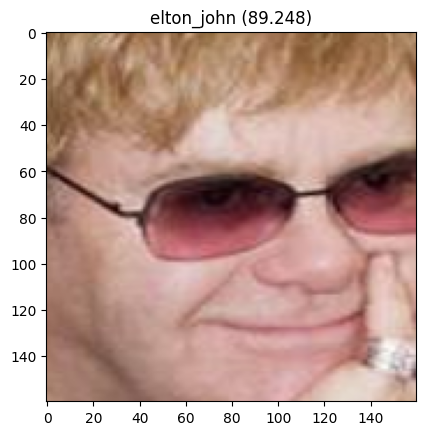

In [84]:
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()